# Lab 1: FinTech Evolution & Python

Fee compression and banking spreads

> **Expected Time**
>
> -   FIN510: Seminar hands‑on ≈ 60 min;
> -   Directed learning extensions ≈ 90–120 min
> -   FIN720: Computer lab ≈ 120 min

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab01_fintech.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

## Setup (Colab‑only installs)

In [1]:
try:
    import matplotlib
except Exception:
    !pip -q install matplotlib

## Objectives

-   Recreate fee compression and NIM visuals
-   Interpret persistence vs compression in finance

## Session Flow (≈ 60 minutes)

> **Suggested Timing**
>
> -   Warm‑up patterns and asserts (10 minutes)
> -   Task 1: Fund fee trends (15 minutes)
> -   Task 2: Banking NIM persistence (15 minutes)
> -   Quality gate for figures + reproducibility note (10 minutes)
> -   Reflection and short write‑up (10 minutes)

This plan keeps you moving between coding, light quality checks, and
interpretation. You can extend any part in directed learning.

## Before You Code: The Big Picture

Financial data science involves three repeating activities.
Understanding this pattern helps you navigate any coding task with
confidence.

> **The Three-Step Pattern You’ll Use Everywhere**
>
> **1. Prepare** → Get your data ready (clean, format, check)  
> **2. Visualize or Analyze** → Create charts or run models  
> **3. Validate** → Check results make sense before trusting them
>
> You’ll use this pattern in every task today. Once you master it here,
> you can apply it to any financial analysis.

### What You’ll Build Today

By the end of this lab, you will have:

-   ✅ Two professional-quality charts (fund fees, bank margins)
-   ✅ Working knowledge of Python plotting basics
-   ✅ Quality checks that catch common data errors
-   ✅ A written interpretation connecting charts to economic theory

**Time estimate:** 60 minutes (FIN510) \| 90-120 minutes (FIN720 with
extensions)

### Coding Confidence Builder

> **🎯 If You’re New to Programming**
>
> **You don’t need to understand every line right away.** Today’s goal
> is pattern recognition:
>
> -   See the structure (prepare → visualize → validate)
> -   Run the code and observe what happens
> -   Modify small things (colors, labels, titles) to build intuition
> -   Understanding will deepen with practice
>
> Professional programmers also look up syntax constantly. The skill is
> knowing *what* you need, not memorizing *how* to type it.

## Mini Exercise — Returns vs Prices (5–10 minutes)

Before we create charts, let’s understand why financial analysis uses
**returns** instead of **prices**. This quick exercise builds intuition.

In [2]:
import pandas as pd, numpy as np

# Try real data; fall back to synthetic if unavailable
try:
    import yfinance as yf
    px = yf.download(["AAPL"], start="2022-01-01", end="2023-01-01", progress=False)["Close"]["AAPL"].dropna()
except Exception:
    px = pd.Series(dtype=float)

if px.shape[0] == 0:
    # Fallback synthetic random walk (business days)
    idx = pd.date_range("2022-01-01", "2023-01-01", freq="B")
    np.random.seed(42)
    r = np.random.normal(0.0005, 0.02, size=len(idx))
    px = pd.Series(150.0 * np.exp(np.cumsum(r)), index=idx, name="AAPL")

# Daily prices, then aggregate to monthly and compute returns
rx_d = px.pct_change().dropna()
px_m = px.resample('M').last()
rx_m = px_m.pct_change().dropna()

px.tail(), rx_d.tail(), rx_m.tail()

(Date
 2022-12-23    130.026215
 2022-12-27    128.221664
 2022-12-28    124.287163
 2022-12-29    127.807526
 2022-12-30    128.123032
 Name: AAPL, dtype: float64,
 Date
 2022-12-23   -0.002798
 2022-12-27   -0.013878
 2022-12-28   -0.030685
 2022-12-29    0.028324
 2022-12-30    0.002469
 Name: AAPL, dtype: float64,
 Date
 2022-08-31   -0.031208
 2022-09-30   -0.120977
 2022-10-31    0.109551
 2022-11-30   -0.033027
 2022-12-31   -0.122273
 Freq: ME, Name: AAPL, dtype: float64)

Notes - Price levels are typically non‑stationary; returns are closer to
stationary and comparable across assets. - In projects, regressions and
forecasts target returns (or excess returns), not price levels.

### Quick patterns and asserts

Introduce defensive checks early so issues are visible and actionable.

In [3]:
import numpy as np

# Guard against empty downloads
assert px.shape[0] > 0, "No price data returned — check ticker or network"

# Confirm monotone date index
assert px.index.is_monotonic_increasing, "Timestamps not monotone — resample/sort before analysis"

# Sanity checks on returns
assert rx_d.abs().lt(1.0).all(), "Extreme daily return detected (>100%) — inspect corporate actions/adjustments"

## Task 1 — Fund Fee Trends

This task recreates the fee compression chart you saw in lecture. We’ll
build it in three steps: prepare data, create the plot, then validate
it.

### Step 1a: Prepare the data

Start with the historical fee data as simple Python lists. These numbers
represent asset-weighted average expense ratios from ICI reports.

In [4]:
# Years we have data for
years = [2000, 2005, 2010, 2015, 2020, 2024]

# Fee data (% of assets under management)
equity_mf = [1.00, 0.85, 0.79, 0.68, 0.50, 0.40]  # Equity mutual funds
bond_mf   = [0.85, 0.75, 0.70, 0.58, 0.45, 0.38]  # Bond mutual funds
index_etf = [0.30, 0.25, 0.20, 0.18, 0.15, 0.14]  # Index ETFs

# Quick look: what's the fee decline for equity funds?
print(f"Equity MF fees fell from {equity_mf[0]:.2f}% to {equity_mf[-1]:.2f}%")
print(f"That's a {(1 - equity_mf[-1]/equity_mf[0])*100:.0f}% reduction over 24 years")

Equity MF fees fell from 1.00% to 0.40%
That's a 60% reduction over 24 years

> **Understanding the Data**
>
> Each list represents one financial product. The numbers decline over
> time—that’s the “compression” story. Notice ETFs started lower and
> fell less (already efficient).

### Step 1b: Create the plot

Now we’ll visualize these three series. Think of this as: (1) create
canvas, (2) add lines, (3) label everything.

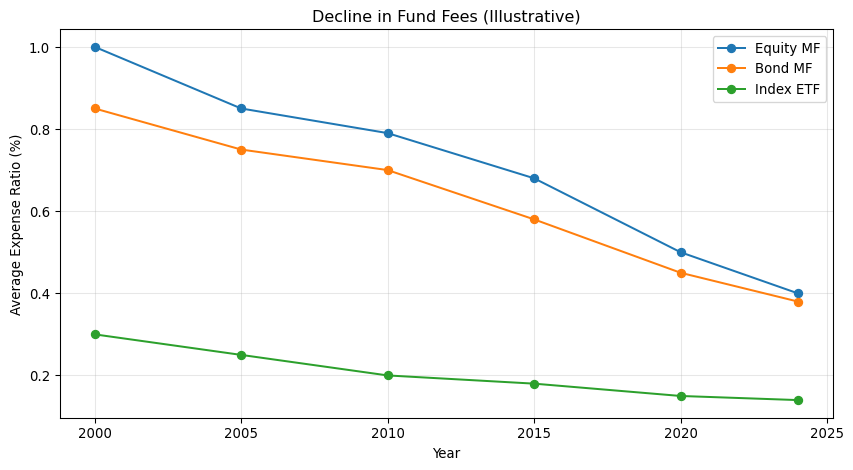

In [5]:
import matplotlib.pyplot as plt

# === STEP 1: Create the canvas ===
plt.figure(figsize=(9,5))  # Size in inches (width, height)

# === STEP 2: Plot each series as a line with markers ===
plt.plot(years, equity_mf, marker='o', label='Equity MF')
plt.plot(years, bond_mf,   marker='o', label='Bond MF')
plt.plot(years, index_etf, marker='o', label='Index ETF')

# === STEP 3: Add labels so readers understand the figure ===
plt.title('Decline in Fund Fees (Illustrative)')
plt.xlabel('Year')
plt.ylabel('Average Expense Ratio (%)')
plt.grid(alpha=0.3)  # Subtle grid helps read values
plt.legend()         # Shows which line is which
plt.tight_layout()   # Prevents labels from being cut off
plt.show()

> **Reading the Code**
>
> -   `plt.plot(x, y, ...)` draws a line from your data
> -   `marker='o'` puts a dot at each data point
> -   `label='...'` names the line for the legend
> -   Each `plt` command adds one more piece to the figure

### Step 1c: Validate your work

Before moving on, run quick checks to catch mistakes early.

In [6]:
# === Quality checks ===
# Do all lists have the same length? (they should!)
assert len(years) == len(equity_mf) == len(bond_mf) == len(index_etf), \
    "Data length mismatch - check your lists"

# Are fees actually declining for equity MFs? (theory says yes)
assert equity_mf[0] > equity_mf[-1], \
    "Equity fees should decline from 2000 to 2024"

print("✔ All checks passed! Your figure is ready.")

✔ All checks passed! Your figure is ready.

> **Why These Checks Matter**
>
> In professional work, data errors are common (typos, missing values,
> wrong units). These `assert` statements catch problems **before** you
> present results. Get in the habit now.

**Pedagogical note:** This three-step pattern (prepare → visualize →
validate) works for nearly every data visualization task. Master it
here, reuse it everywhere.

## Task 2 — Banking NIM Persistence

Now you’ll recreate the banking spreads chart. Notice how this pattern
mirrors Task 1—that’s intentional! Professional workflows reuse reliable
patterns.

### Step 2a: Prepare NIM data

In [7]:
# Same years as before
years = [2000, 2005, 2010, 2015, 2020, 2024]

# Bank net interest margins (%)
nim = [3.9, 3.5, 3.6, 2.9, 2.6, 3.0]

# Quick comparison: how stable are NIMs vs fund fees?
print(f"NIM in 2000: {nim[0]:.1f}%")
print(f"NIM in 2024: {nim[-1]:.1f}%")
print(f"Change: {nim[-1] - nim[0]:.1f} percentage points (compare to equity MF: {equity_mf[-1] - equity_mf[0]:.1f})")

NIM in 2000: 3.9%
NIM in 2024: 3.0%
Change: -0.9 percentage points (compare to equity MF: -0.6)

> **The Key Contrast**
>
> Fund fees **compressed** (fell 0.6 pp). Bank NIMs **persisted** (fell
> only 0.9 pp, and oscillated). This is the puzzle!

### Step 2b: Create the plot

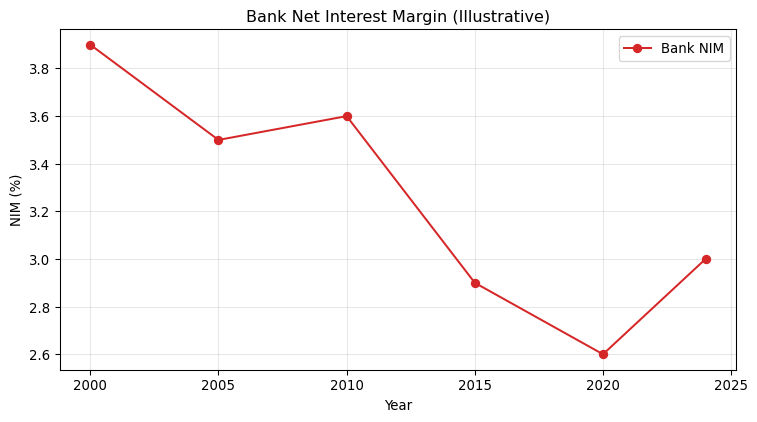

In [8]:
# === Create canvas and plot ===
plt.figure(figsize=(8,4.5))
plt.plot(years, nim, marker='o', color='tab:red', label='Bank NIM')

# === Label everything ===
plt.title('Bank Net Interest Margin (Illustrative)')
plt.xlabel('Year')
plt.ylabel('NIM (%)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Step 2c: Validate

In [9]:
# Check data consistency
assert len(years) == len(nim), "Data length mismatch"

# Unlike fees, NIMs don't monotonically decline (they oscillate with policy rates)
# So we just check they're in a reasonable range
assert all(0 < n < 10 for n in nim), "NIMs should be between 0-10%"

print("✔ NIM chart checks passed")

✔ NIM chart checks passed

> **Try This Yourself**
>
> Before running the code, **predict** what the chart will show. Will it
> look like the fund fee chart (steady decline) or different? Then
> compare your prediction to the result. This active prediction
> strengthens learning.

## Quality Gate for Figures (10 minutes)

Before interpretation, run a tiny “figure quality gate” on your inputs
and outputs.

In [10]:
import pandas as pd

# Wrap your plotting inputs into DataFrames for simple checks
fees_df = pd.DataFrame({
    'year': years,
    'equity_mf': equity_mf,
    'bond_mf': bond_mf,
    'index_etf': index_etf
})

nim_df = pd.DataFrame({
    'year': years,
    'nim': nim
})

checks = {
    'fees_monotone_decline_equity': pd.Series(equity_mf).is_monotonic_decreasing,
    'fees_monotone_decline_bond': pd.Series(bond_mf).is_monotonic_decreasing,
    'nim_reasonable_range': (pd.Series(nim).between(0.0, 10.0).all()),
    'year_sorted': pd.Series(years).is_monotonic_increasing
}

checks

{'fees_monotone_decline_equity': True,
 'fees_monotone_decline_bond': True,
 'nim_reasonable_range': np.True_,
 'year_sorted': True}

Briefly explain any violations (e.g., non‑monotonic segments in bond
fees) rather than forcing the data to fit an assumption.

## Task 3 — Adjusted vs Unadjusted Prices (10–15 minutes)

Corporate actions change the interpretation of price series. Compare
adjusted and unadjusted series and discuss implications for analysis.

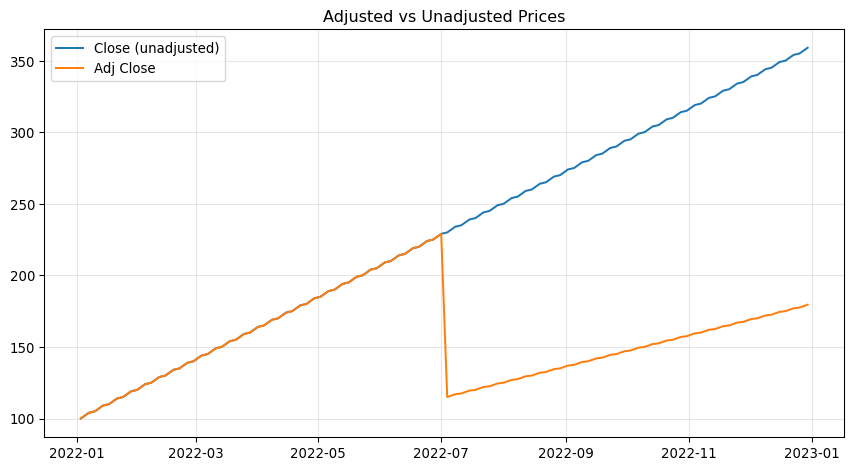

Mean daily return (Close): 0.495%
Mean daily return (Adj):   0.301%

In [11]:
import yfinance as yf, pandas as pd, matplotlib.pyplot as plt

try:
    raw = yf.download(["AAPL"], start="2022-01-01", end="2023-01-01", progress=False)
    close = raw["Close"]["AAPL"].dropna()
    adj   = raw["Adj Close"]["AAPL"].dropna()
except Exception:
    # Fallback synthetic series with a one‑off adjustment event
    idx = pd.date_range('2022-01-01','2023-01-01', freq='B')
    close = pd.Series(100.0, index=idx).add(pd.Series(range(len(idx)), index=idx)).astype(float)
    adj = close.copy()
    adj.iloc[len(adj)//2:] = adj.iloc[len(adj)//2:] * 0.5  # simulate split

ret_close = close.pct_change().dropna()
ret_adj   = adj.pct_change().dropna()

plt.figure(figsize=(9,5))
plt.plot(close.index, close, label='Close (unadjusted)')
plt.plot(adj.index, adj, label='Adj Close')
plt.title('Adjusted vs Unadjusted Prices')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print(f"Mean daily return (Close): {ret_close.mean()*100:.3f}%")
print(f"Mean daily return (Adj):   {ret_adj.mean()*100:.3f}%")

Notes

-   Adjusted series backfills splits/dividends, making return
    calculations coherent.
-   For cross‑section and long horizons, prefer adjusted prices;
    document the choice.

## Reproducibility Snapshot (2 minutes)

Record minimal environment and metadata with your submission.

In [12]:
import sys, platform, json
meta = {
    'python': sys.version.split()[0],
    'platform': platform.platform(),
    'data_sources': ['Illustrative lists', 'yfinance (optional)'],
}
json.dumps(meta, indent=2)

'{\n  "python": "3.11.13",\n  "platform": "macOS-26.0.1-arm64-arm-64bit",\n  "data_sources": [\n    "Illustrative lists",\n    "yfinance (optional)"\n  ]\n}'

## Reflection Prompts (10 minutes)

Write 150–250 words addressing:

-   Why did fees compress while NIMs persisted? Tie to functions of
    finance and market structure.
-   What risks arise from using unadjusted prices in analysis? Give one
    concrete example.
-   One specific check you would add to a production data pipeline and
    why.

> **Brief Rubric (FIN510)**
>
> -   Evidence use: references figures and economic mechanisms
> -   Clarity: concise, logically structured, avoids jargon where
>     unnecessary
> -   Method awareness: acknowledges data/measurement limitations

## Stretch (FIN720 or extensions)

Optional deeper tasks:

-   Replicate the NIM series from a public source (e.g., FRED) and
    compare levels/trends.
-   Extend fee analysis to include advisory fees vs fund fees; discuss
    scope differences.
-   Draft a short memo (200–300 words) critiquing a fintech claim using
    your figures.

## Submission Checklist

-   Two figures (fees, NIM) rendered and saved
-   Quality gate output shown and discussed
-   Reflection (150–250 words) attached
-   Reproducibility snapshot included

> **Troubleshooting**
>
> -   If lines don’t show, ensure values are numeric floats (not
>     strings).
> -   If legends overlap: reduce figure size or call
>     `plt.tight_layout()`.

## Save Outputs (optional)

In [13]:
import matplotlib.pyplot as plt
plt.savefig('lab01_last_figure.png', dpi=150)
"Saved: lab01_last_figure.png"

'Saved: lab01_last_figure.png'

<Figure size 672x480 with 0 Axes>

> **Further Reading (Hilpisch 2019)**
>
> -   See: [Hilpisch Code Resources](../resources/hilpisch-code.qmd) —
>     Week 1
> -   Chapter 03 (data structures & plotting) provides additional
>     plotting patterns you can adapt for fee/NIM visuals.